This tutorial demonstrates how to use FEniCS and the `phaseflow.AbstractSimulation` class as an application programming interface (API) for implementing time-dependent simulations with goal-oriented adaptive mesh refinement (AMR).

First, import Phaseflow, FEniCS, and matplotlib.

In [1]:
import phaseflow
import fenics
import matplotlib
%matplotlib inline

To implement a simulation, we must define a class which inherits from Phaseflow's `AbstractSimulation` class. One must inherit from the abstract class and overload its abstract methods to define an instantiable class. These are analogous to `pure virtual` methods in C++. In this tutorial, we will define a minimal example which only overloads the required methods. 

First we implement the unsteady incompressible Navier-Stokes equations in variational form, including the dynamic viscosity as a parameter.

In [2]:
class IncompressibleFlowAbstractSimulation(
        phaseflow.simulation.AbstractSimulation):

    def __init__(self):
        """ Extend the constructor with parameters for this simulation. """
        self.dynamic_viscosity = fenics.Constant(0.01, name = "mu")
        
        phaseflow.simulation.AbstractSimulation.__init__(self)        
        
    def element(self):
        """ Make the P2P1 (Taylor-Hood) mixed element. """
        P2 = fenics.VectorElement("P", self.mesh.ufl_cell(), 2)
        
        P1 = fenics.FiniteElement("P", self.mesh.ufl_cell(), 1)
        
        return fenics.MixedElement([P2, P1])
        
        
    def governing_form(self):
        """ Set the variational form for the governing equations. """
        u, p = fenics.split(self.solution)
        
        u_t, p_t = self.time_discrete_terms()
        
        mu = self.dynamic_viscosity
        
        psi_u, psi_p = fenics.TestFunctions(self.function_space)
        
        dx = self.integration_measure
        
        inner, dot, grad, div, sym = \
            fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym
        
        mass = -psi_p*div(u)
        
        momentum = dot(psi_u, u_t + dot(grad(u), u)) - div(psi_u)*p \
            + 2.*mu*inner(sym(grad(psi_u)), sym(grad(u)))
            
        F = (mass + momentum)*dx
        
        return F

Next we define a simulation for the lid-driven cavity benchmark problem. While the benchmark is usually only considered at steady state, with small time step sizes we can observe the unsteady evolution of the velocity field which eventually reaches steady state.

In [3]:
class LidDrivenCavitySimulation(IncompressibleFlowAbstractSimulation):
    """ Implements the well-known lid-driven cavity benchmark. """
    def __init__(self):
        """Extend the constructor with attributes for this simulation. """
        self.lid_horizontal_velocity = 1.
        
        class Lid(fenics.SubDomain):

            def inside(self, x, on_boundary):

                return on_boundary and fenics.near(x[1], 1.)

        self.lid = Lid()
        
        class FixedWalls(fenics.SubDomain):

            def inside(self, x, on_boundary):

                return on_boundary and (not fenics.near(x[1], 1.))

        self.fixed_walls = FixedWalls()
        
        class BottomWall(fenics.SubDomain):

            def inside(self, x, on_boundary):

                return on_boundary and fenics.near(x[1], 0.)
                                        
        self.bottom_wall = BottomWall()
        
        super().__init__()
        
    def coarse_mesh(self):
        """ This creates a coarse mesh on the unit square. """
        return fenics.UnitSquareMesh(4, 4)
    
    def initial_values(self):
        """ Set initial values which are consistent with the boundary conditions. """
        u0 = str(self.lid_horizontal_velocity) + "*near(x[1], 1.)"
        
        u1 = "0."
        
        p = "0."
                                        
        return fenics.interpolate(
            fenics.Expression(
                (u0, u1, p),
                element = self.element()),
            self.function_space)
    
    def boundary_conditions(self):
        """ Define no-slip boundary conditions. """
        return [
            fenics.DirichletBC(
                self.function_space.sub(0), 
                (0., 0.), 
                self.fixed_walls),
            fenics.DirichletBC(
                self.function_space.sub(0), 
                (self.lid_horizontal_velocity, 0.), 
                self.lid)]
                            
    def bottom_wall_shear_integrand(self):
    
        nhat = fenics.FacetNormal(self.mesh)
    
        u, p = fenics.split(self.solution)
        
        bottom_wall_id = 2
        
        mesh_function = fenics.MeshFunction(
            "size_t", 
            self.mesh, 
            self.mesh.topology().dim() - 1)
        
        self.bottom_wall.mark(mesh_function, bottom_wall_id)
        
        dot, grad = fenics.dot, fenics.grad
        
        ds = fenics.ds(
            domain = self.mesh, 
            subdomain_data = mesh_function, 
            subdomain_id = bottom_wall_id)
        
        return dot(grad(u[0]), nhat)*ds
                                        
    def adaptive_goal(self):
        """ Define adaptive goal which resolves shear on the bottom wall.
        
        The default refinement algorithm in FEniCS has a 'known bug' 
        which prevents us from integrating a goal over a subdomain, 
        referenced in the following:
          - https://fenicsproject.org/qa/6719/using-adapt-on-a-meshfunction-looking-for-a-working-example/
          - https://bitbucket.org/fenics-project/dolfin/issues/105/most-refinement-algorithms-do-not-set
        So we follow their advice and set the following algorithim.
        """
        fenics.parameters["refinement_algorithm"] = "plaza_with_parent_facets"
        
        return self.bottom_wall_shear_integrand()

Now we instantiate our simulation and plot the initial values.

In [4]:
sim = LidDrivenCavitySimulation()

and run it for a time step.

In [5]:
sim.assign_initial_values()

sim.timestep_size = 1.

sim.solve(goal_tolerance = 0.001)

Before continuing, let's see how the solution and the adapted mesh look.

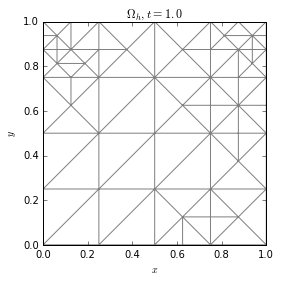

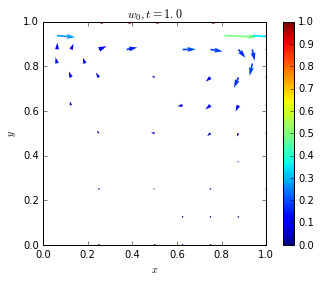

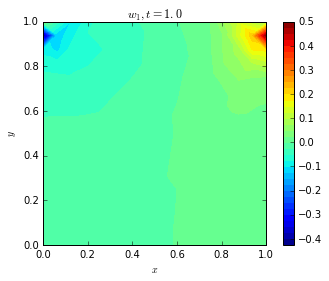

In [6]:
sim.plot()

This looks somewhat reasonable. Let's run for a few more time steps and check again.

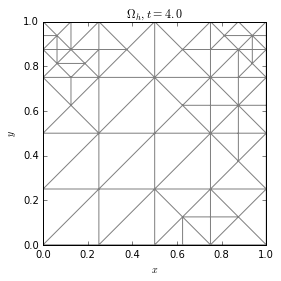

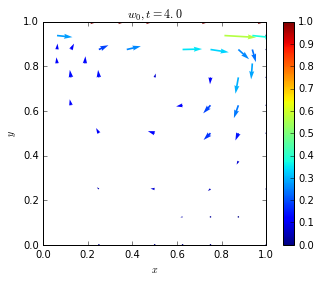

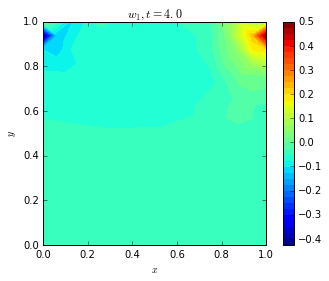

In [7]:
for it in range(3):
    
    sim.advance()

    sim.solve(goal_tolerance = 0.001)

sim.plot()

Let's try a large time step and check how much the solution is changing in time.

0.015491297371621313


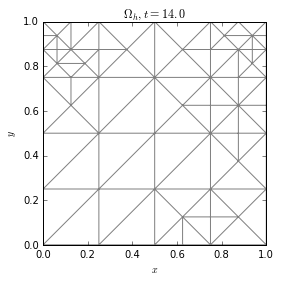

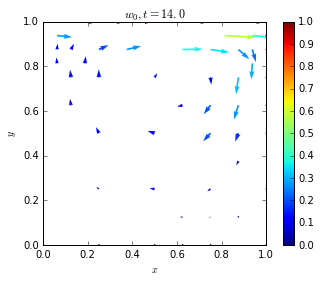

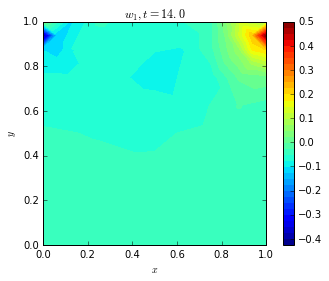

In [8]:
sim.timestep_size = 10.

sim.advance()

sim.solve(goal_tolerance = 0.001)
    
u, p = sim.solution.split()

u_n, p_n = sim._solutions[1].leaf_node().split()

print(fenics.errornorm(u, u_n, "L2"))

sim.plot()

The time residual is still significant. Let's see what happens when we take an arbitrarily large time step, which approximates the steady state solution.

0.0028273201813269304


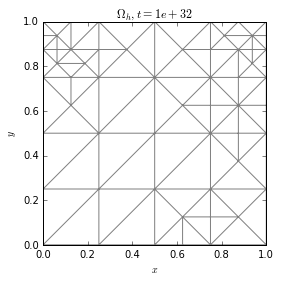

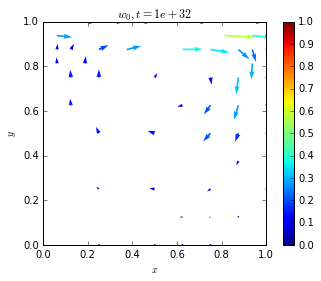

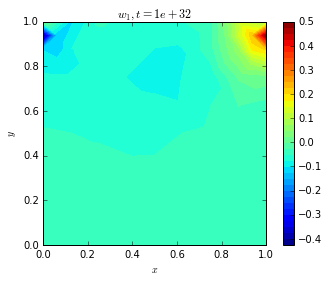

In [9]:
sim.advance()

sim.timestep_size = 1.e32

sim.solve(goal_tolerance = 0.001)
    
u, p = sim.solution.split()

u_n, p_n = sim._solutions[1].leaf_node().split()

print(fenics.errornorm(u, u_n, "L2"))
    
sim.plot()

Let's try one more step.

0.0


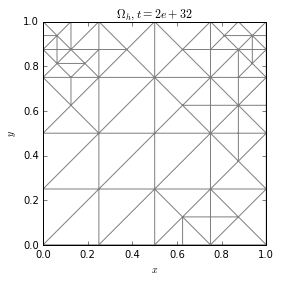

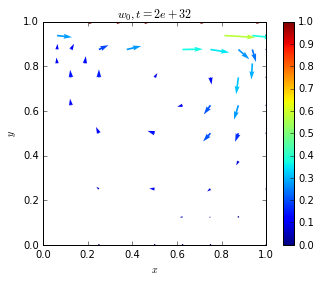

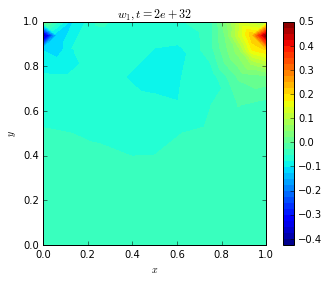

In [10]:
sim.advance()

sim.solve(goal_tolerance = 0.001)
    
u, p = sim.solution.split()

u_n, p_n = sim._solutions[1].leaf_node().split()

print(fenics.errornorm(u, u_n, "L2"))

sim.plot()

Now the time residual is zero, i.e. we have reached steady state.

We began with small time steps to demonsrate the time dependent simulation, since one generally would not benefit much from using `phaseflow.simulation.AbstractSimulation` for steady state simulations. In this case, though, we can actually begin with arbitrarily large time steps. This does not work for all problems. Here's a quick demonstration:

0.0


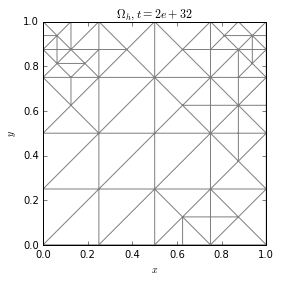

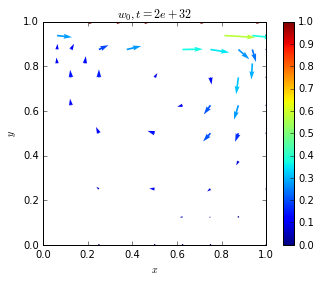

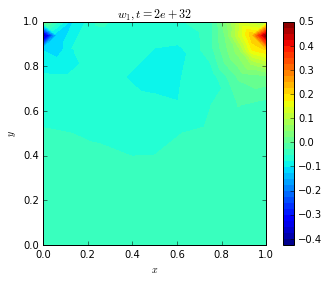

In [11]:
sim2 = LidDrivenCavitySimulation()

sim2.timestep_size = 1.e32

sim2.solve(goal_tolerance = 0.001)

sim2.advance()

sim2.solve(goal_tolerance = 0.001)

u, p = sim2.solution.split()

u_n, p_n = sim2._solutions[1].leaf_node().split()

print(fenics.errornorm(u, u_n, "L2"))

sim.plot()